# 1. Introduction

## Guidelines
Please complete the assignment inside this notebook. Make sure the code can be executed easily.

- Write production-ready code.
- Create unit tests for your code where applicable.
- Add comments and documentation strings for all methods. Also discuss your design choices.
- Discuss the complexity (Big O notation) of your solutions, both memory wise and performance wise.
- Try to stick to the most popular scientific Python libraries.

## Input data
You should have received three csv files. Each csv-file represents the locations where a person was stationary for a certain amount of time. 
The csv-files contain the following fields:

- Latitude: The latitude of the detected GPS coordinates Longitude: The longitude of the detected GPS coordinates
- Timestamp: The start time of the stationary in the following format:
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
- Duration: The length of time the person was stationary (in milliseconds)
    
All questions in this assignment are related to this data.

In [19]:
# import statements go here.
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib  import cm
import numpy as np
import random
import math
import sklearn
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 2. Programming skills

## Question 1: Data parsing
- Create the code needed to read and parse the data.
- Print out some summary statistics of the data
    - e.g. Average number of places visited per day
    - e.g. Median distance traveled between two subsequent stationary locations
    - ...

In [2]:
def read_csv (filename):
    df = pd.read_csv (filename, sep = ';')
    # convert string to datetime
    df['time'] = pd.to_datetime (df['start_time(YYYYMMddHHmmZ)'])
    df.rename (columns={'start_time(YYYYMMddHHmmZ)':'start_time'}, inplace = True)
    return df

In [3]:
# read CSV files
person1 = read_csv ("person.1.csv")
person2 = read_csv ("person.2.csv")
person3 = read_csv ("person.3.csv")

In [4]:
# print first few lines of each data
print (person1.head (n=2))
print (person2.head (n=2))
print (person3.head (n=2))

    latitude  longitude         start_time  duration(ms)                time
0 -49.326958  -72.89073  201312251147-0300       1186491 2013-12-25 14:47:00
1 -49.326930  -72.89073  201312251213-0300       4393711 2013-12-25 15:13:00
    latitude  longitude         start_time  duration(ms)                time
0  51.057022   3.714476  201312250036+0100      19593588 2013-12-24 23:36:00
1  51.056984   3.714681  201312250608+0100      30460679 2013-12-25 05:08:00
    latitude  longitude         start_time  duration(ms)                time
0  51.216340   4.394143  201401061340+0100       9488434 2014-01-06 12:40:00
1  51.205994   4.392227  201401061631+0100        430394 2014-01-06 15:31:00


In [5]:
# visualize the visited place in one day of one person
def visualize_visits (df):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_xlabel("latitude",fontsize=12)
    ax.set_ylabel("longitude",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    z = df.time.apply(lambda x:x.hour) / 8
    z = z.astype (int)
    ax.scatter(x = df['latitude'], y = df['longitude'], s=100,
               c = z, marker = 'o', cmap = cm.jet );
    plt.show()

In [6]:
def sample(df, n):
    # sample n rows from a pandas dataframe
    return df.ix[random.sample(df.index, n)]

/Users/qdang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


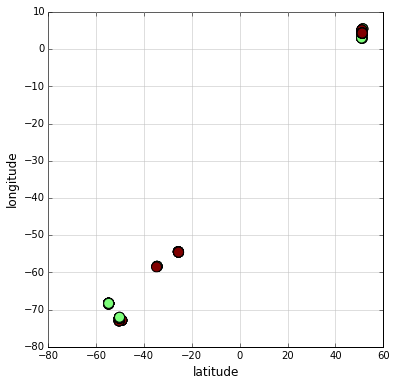

In [7]:
# visualize moves of a person
visualize_visits (person1)

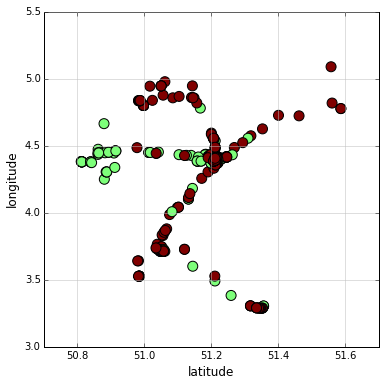

In [8]:
visualize_visits (person2)

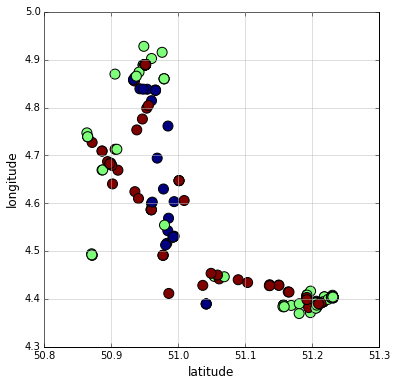

In [9]:
visualize_visits (person3)

In [10]:
def get_distances (df):
    # get travelled distances
    N = len (df.index)
    distances = []
    days = df.time.apply (lambda x:x.day)
    for i in xrange (N - 2):
        if days[i] == days[i+1]:
            distance = math.sqrt ((df['latitude'][i] - df['latitude'][i + 1])**2 
                                  + (df['longitude'][i] - df['longitude'][i + 1])**2)
            distances.append (distance)
    return distances

In [11]:
# get median
print ('Median of moving distances of person 1: ' + str(np.median (get_distances (person1))))
print ('Median of moving distances of person 2: ' + str(np.median (get_distances (person2))))
print ('Median of moving distances of person 3: ' + str(np.median (get_distances (person3))))

Median of moving distances of person 1: 0.00455032141722
Median of moving distances of person 2: 0.00466192123183
Median of moving distances of person 3: 0.0302640670666


## Question 2: Data lookup
Create a method that generates a lookup table allowing us to effiently check whether or not a user has ever visited a location even if the new location is not exactly the same as the visited location (some noise is added to the longitude/latitude pairs).

In [12]:
def build_visited_database (df):
    # using KDTree to store the visited information
    latitude = df['latitude'].tolist()
    longitude = df['longitude'].tolist()
    X = [list(a) for a in zip(latitude, longitude)]
    tree = KDTree (X, leaf_size =10)
    return tree

def check_visited (place, kdTree, distance_threshold = 1):
    # check if a person visited place within the distance threshold
    dist, ind = kdTree.query(place, k=1) 
    if dist[0] < distance_threshold:
        return True
    return False

In [13]:
# test the solution
db1 = build_visited_database (person1)
place1 = np.array ([49,73])
print (check_visited(place1, db1))
place1 = np.array ([-49,-73])
print (check_visited(place1, db1))

False
True


/Users/qdang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/qdang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# 3. Machine learning skills

## Question 1: Home and work detection
The goal of this question, is to design an algorithm that allows us to distinguish the likely home locations of a user from his likely work locations.

Note that a person might have multiple home and work locations, or might not have a work location at all. Also note that the data might be noise, incorrect and/or incomplete.

Discuss your choice of algorithms, rules, methods, distance measures, etc.

In [14]:
def plot3d (df):
    # plot moves of a person in 3d style with time information
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    z = df.time.apply(lambda x:x.hour) / 8
    z = z.astype (int)
    
    ax.scatter (df['latitude'], df['longitude'], z, c=z)

    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    ax.set_zlabel('hour')

    plt.show()
    

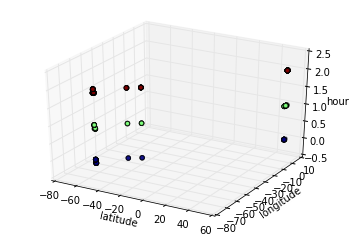

In [15]:
plot3d(person1)

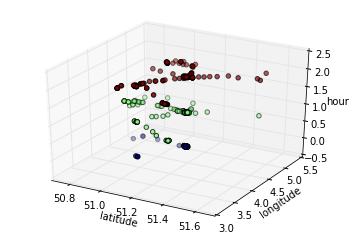

In [16]:
plot3d(person2)

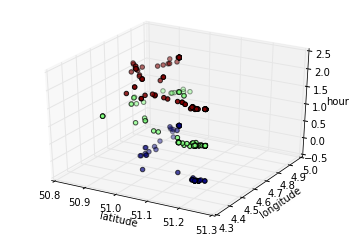

In [17]:
plot3d(person3)

In [40]:
# try with k-means
def plot3d_kmean (df):
    # plot moves of a person in 3d style with time information
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    trans_markers = {0:'o',1:'v',2:'s'}
    trans_colors = {0:'r',1:'g',2:'b'}
    
    for i in xrange (len (df.index)):
        ax.scatter (df.iloc[i]['latitude'], df.iloc[i]['longitude'], df.iloc[i]['day_part'], 
                    c = trans_colors[df.iloc[i]['day_part']], 
                    marker = trans_markers[df.iloc[i]['labels']])

    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    ax.set_zlabel('hour')

    plt.show()

def kmean (df):
    km = KMeans (n_clusters = 3)
    z = df.time.apply(lambda x:x.hour) / 8
    z = z.astype (int)
    df['day_part'] = z
    km.fit (df[['latitude','longitude','day_part']])
    df['labels'] = km.labels_
    plot3d_kmean(df)
    return km

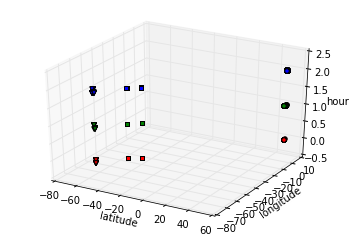

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
kmean (person1)

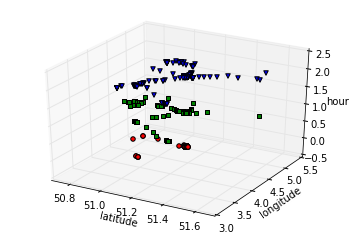

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [42]:
kmean (person2)

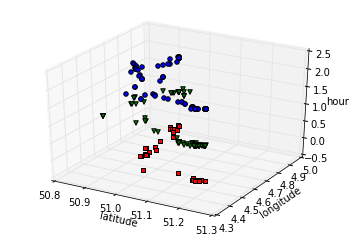

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
kmean (person3)

### Discussion

I used k-means algorithms with 3 clusters to cluster the positions of each person. The main idea is by dividing a day into 3 parts (variable `day_parts`): from 0 - 8AM, 8AM - 4PM and the rest. It is reasonable to believe that during the part 0-8AM a person should be in their house, and in 8AM - 4PM (s)he should be in their working place.

The clustering algorithm person 2 and 3 are quite clear: they are in different places in different timeframes. However, the move history of person 1 is quite weird. Probably (s)he just move around?

## Question 2: Social graph
- Try to uncover the geo-spatial similarities between the users' data. Do users visit similar places? Are they likely to know each other?
- Figure out a way to describe how 'socially active' each user is, by designing some kind of action radius metric. This metric should should take into account how many places a user visits, how far these places are away from each other, and how long the user stays there. The metric should allow us to compare users and to flag the most socially active one.

In [89]:
# first let's plot person moves in one graph
def plot_mult_persons (dfs, xlim = [-100,100], ylim = [-100,100]):
    #dfs: a list of dataframe
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_xlabel("latitude",fontsize=12)
    ax.set_ylabel("longitude",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    ax.set_xlim (xlim)
    ax.set_ylim (ylim)
    
    trans_markers = {0:'o',1:'v',2:'s'}
    trans_colors = {0:'r',1:'g',2:'b'}
    
    for i in xrange (len (dfs)):
        df = dfs[i]
        z = df.time.apply(lambda x:x.hour) / 8
        z = z.astype (int)
        df['day_part'] = z
        for j in xrange (len (df.index)):
            ax.scatter(x = df.iloc[j]['latitude'], y = df.iloc[j]['longitude'], s=110,
               c = trans_colors[i], marker = trans_markers[z[j]]
                  )
    plt.show()

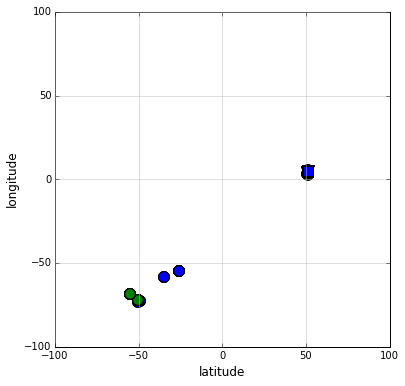

In [85]:
plot_mult_persons ([person1,  person2, person3])
# It seems that person 2 and 3 are quite close together

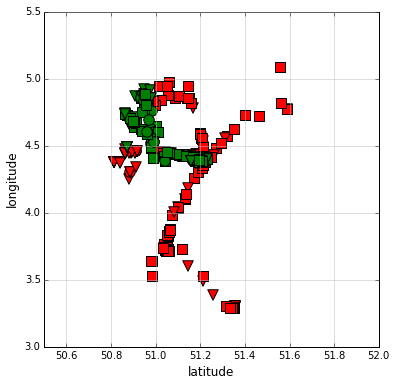

In [90]:
# Let's zoom into person 2 and 3
plot_mult_persons ([person2, person3], xlim = [50.5,52], ylim = [3,5.5])

### Discussion about metrics

#### A stay

First of all we need to define a **stay**, i.e. when can we say if a person moves to a different location, or (s)he is moving inside a place.
The idea is a person 

In [ ]:
def is_moving_another_place (df, i, threshold):
    '''
    df: person dataframe
    i: index
    '''
    if i == 0:
        return False
    d = distance = math.sqrt ((df['latitude'][i - 1] - df['latitude'][i])**2 
                                  + (df['longitude'][i - 1] - df['longitude'][i])**2)
    if d > threshold:
        return True
    return False

#### A circle

Now we define an **activity circle** of a person, defined by a circle that cover all the points inside a place that a person moves.

In [ ]:
class ActivityCircle ():
    def __init__ (self, x, y, r):
        self.x = x
        self.y = y
        self.r = r

def circle (df, radius_ratio):
    cur_circle = ActivityCircle (0,0,-1)
    cur_duration = 0
    cur_circle_count = 0
    res = []
    for i in xrange (len (df.index)):
        if is_moving_another_place (df, i):
            res.append (cur_circle)
            cur_circle = ActivityCircle (df.iloc[i]['latitude'],
                                         df.iloc[i]['longitude'],
                                         df.iloc[i]['duration(ms)' * radius_ratio]
                                        )
            cur_circle_count += 1
        else:
            new_x = (cur_circle.x * cur_circle_count + df.iloc[i]['latitude']) / (cur_circle_count + 1)
            new_y = (cur_circle.y * cur_circle_count + df.iloc[i]['longitude']) / (cur_circle_count + 1)
            new_duration = duration + df.iloc[i]['duration(ms)']
            cur_circle.x = new_x
            cur_circle.y = new_y
            cur_circle.r = new_duration * radius_ratio
    return res